<font size="6"> **Portfolio Optimization** </font>

In [1]:
%%capture
%run 00_portopt_data.ipynb

In [40]:
import datetime as dt

from tqdm import tqdm

from src.mle_quant_utils import portopt_utils
from src.portfolio_opt import cvx_opt, cvx_opt_tc

In [3]:
RND_SEED = 123

# Statistical Risk Model

In [4]:
risk_model.keys()

dict_keys(['idiosyncratic_var_vector', 'factor_var_vector', 'factor_betas', 'factor_returns'])

In [5]:
risk_model['factor_betas'].shape

(490, 20)

In [6]:
risk_model['factor_cov_matrix'] = np.diag(risk_model['factor_var_vector']['0'].values)
risk_model['factor_cov_matrix'].shape

(20, 20)

In [7]:
risk_model['idiosyncratic_var_vector'].shape

(490, 1)

# Portfolio Optimization

## No Transaction Costs

In [8]:
opt_engine_notc = cvx_opt.OptimalHoldingsRegualization(lambda_reg=5.0)

In [9]:
bkt_dates = test_dates.unique()
bkt_daily_returns = daily_returns.loc[bkt_dates].copy()
bkt_daily_adv = adv.loc[bkt_dates].copy()

In [46]:
res_simple_avg_combi = portopt_utils.run_backtesting(opt_engine_notc, B_alpha['avg_combi_alpha'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=2)
pnl_simple_avg_combi, w_simple_avg_combi = res_simple_avg_combi

Opt portfolio: 100%|██████████| 149/149 [00:42<00:00,  3.52portfolio/s]


In [47]:
res_simple_ml = portopt_utils.run_backtesting(opt_engine_notc, B_alpha['ml_alpha'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=2)
pnl_simple_ml, w_simple_ml = res_simple_ml

Opt portfolio: 100%|██████████| 149/149 [00:48<00:00,  3.07portfolio/s]


In [92]:
B_alpha.columns

Index(['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed', 'avg_combi_alpha', 'ml_alpha'],
      dtype='object')

In [96]:
res_simple_1yrmon = portopt_utils.run_backtesting(opt_engine_notc, B_alpha['Momentum_1YR_Smoothed'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=2)
pnl_simple_1yrmon, w_simple_1yrmon = res_simple_1yrmon

Opt portfolio: 100%|██████████| 149/149 [00:39<00:00,  3.75portfolio/s]


In [112]:
res_simple_5dmrev = portopt_utils.run_backtesting(opt_engine_notc, B_alpha['Mean_Reversion_Sector_Neutral_Smoothed'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=2)
pnl_simple_5dmrev, w_simple_5dmrev = res_simple_5dmrev

Opt portfolio: 100%|██████████| 149/149 [00:41<00:00,  3.61portfolio/s]


In [113]:
pnl_simple_avg_combi['port_name'] = 'simple_avg_combi'
pnl_simple_5dmrev['port_name'] = 'Mean_Reversion_Sector_Neutral_Smoothed'
pnl_simple_1yrmon['port_name'] = 'Momentum_1YR_Smoothed'
pnl_simple_ml['port_name'] = 'simple_ml'
pnl_simple_app = pd.concat([ pnl_simple_1yrmon, pnl_simple_5dmrev, pnl_simple_avg_combi, pnl_simple_ml ], axis=0)

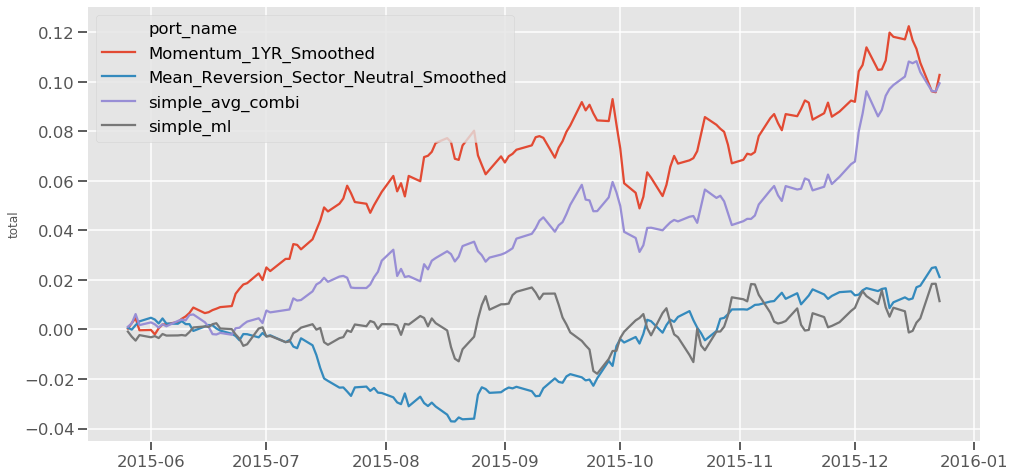

In [114]:
sns.lineplot(x=pnl_simple_app.index.values, y=pnl_simple_app['total'],  hue=pnl_simple_app['port_name'])

## Transaction Costs

In [49]:
res_engine_tc = cvx_opt.OptimalHoldingsRegualization(lambda_reg=5.0)

In [50]:
res_tc_avg_combi = portopt_utils.run_backtesting(opt_engine_tc, B_alpha['avg_combi_alpha'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=2)
pnl_tc_avg_combi, w_tc_avg_combi = res_tc_avg_combi

Opt portfolio: 100%|██████████| 149/149 [00:44<00:00,  3.37portfolio/s]


In [52]:
res_tc_ml = portopt_utils.run_backtesting(opt_engine_tc, B_alpha['ml_alpha'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=2)
pnl_tc_ml, w_tc_ml = res_tc_ml

Opt portfolio: 100%|██████████| 149/149 [00:47<00:00,  3.15portfolio/s]


In [59]:
pnl_tc_avg_combi['port_name'] = 'tc_avg_combi'
pnl_tc_ml['port_name'] = 'tc_ml'

In [86]:
pnl_tc_app = pd.concat([pnl_simple_avg_combi, pnl_simple_ml], axis=0)
pnl_simple_app = pd.concat([ pnl_tc_avg_combi, pnl_tc_ml ], axis=0)

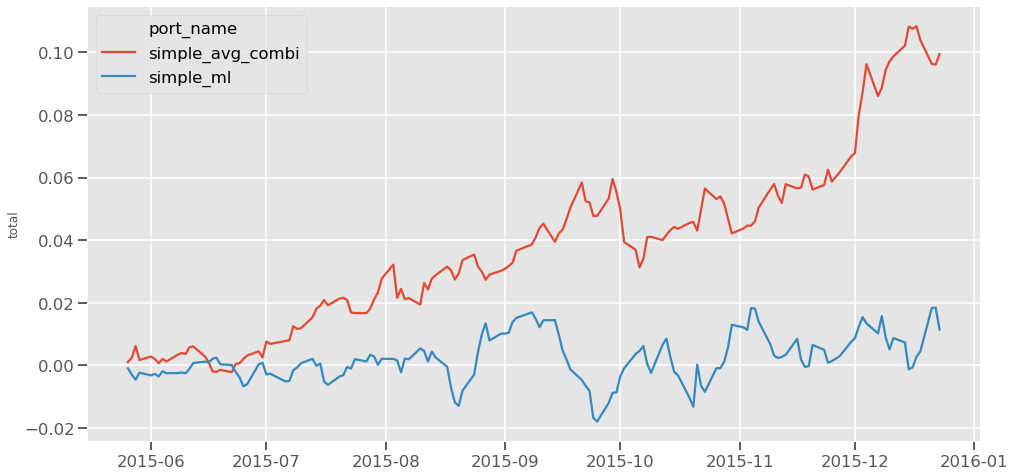

In [99]:
sns.lineplot(x=pnl_tc_app.index.values, y=pnl_tc_app['total'],  hue=pnl_tc_app['port_name'])

In [88]:
pnl_tc_stats = pnl_tc_app.groupby('port_name')['daily_pnl'].agg([np.mean, np.std])

In [90]:
pnl_tc_stats['sharpe_ratio'] = pnl_tc_stats['mean'] / pnl_tc_stats['std']

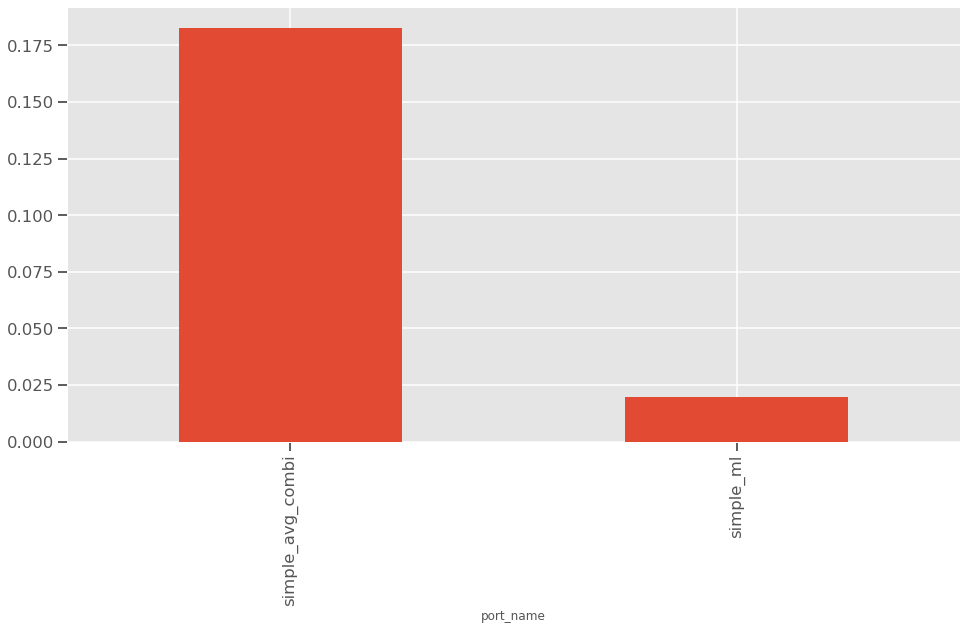

In [91]:
pnl_tc_stats['sharpe_ratio'].plot.bar()